# Understanding ICU free days through density-based clustering of patient and mechanical ventilation data features

# Clustering



This notebooks is structured as follows:

1. Data loading
2. Inspection of missing data-related potential issues?
3. Overview of the variables considered
4. Preprocessing: Derive further fields, required to characterize or
annotate labels
5. Preprocessing: Categorical -> Integers, Numerical -> Mean=0, Std=1, Mean
imputation
6. Clustering and result visualization for the scenarios considered:
6a. Using all patient and mech. vent. parameters to characterize the sample
6b. Using exclusively patient parameters.
6c. Using exclusively mechanical ventilation parameters.


In [1]:
# Imports
import pandas
import numpy
import umap
import hdbscan
from typing import Union, List

from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Global variables
ROOT = Path.cwd().parent
DATA = ROOT / 'data'

# Load the main database & filter by med criteria
dataset = pandas.read_csv(DATA / 'final_transformed_table.csv')
patients = list(pandas.read_csv(
    DATA / 'firstcodestatus_full_code.csv').values)


# When merging SQL, some columns get duplicated: subject_id, stay_id,
# hadm_id...
def remove_duplicate_cols(cols: list) -> list:
    keep = []
    remove = []
    for col in cols:
        raw = col.split('_')
        if not '_'.join(raw[:-1]) in keep and not col == '_220283':
            keep.append(col)
        else:
            remove.append(col)
    return keep


cols2keep = remove_duplicate_cols(list(dataset))
dataset = dataset[cols2keep]
dataset = dataset[dataset['stay_id'].isin(patients)]
dataset

,Unnamed: 0,subject_id,stay_id,respiratory_rate_total,minute_volume,tidal_volume_observed,plateau_pressure,peep,fio2,outcome_los,...,liver,cardiovascular,cns,renal,weight,neuroblock,charlson_comorbidity_index,_223835,_224695,mechanical_power
0,0,10734403,36647759,24.0,12.0,855.0,20.0,15.0,100.0,3.923854,...,0.0,1.0,0.0,3.0,94.90,1,6.0,80.540541,25.333333,45.916920
1,1,12341414,34948580,29.0,11.5,548.0,NaN,5.0,50.0,2.911609,...,1.0,0.0,1.0,3.0,86.20,0,5.0,50.000000,14.000000,NaN
2,2,16427415,37704589,27.0,11.1,505.0,NaN,5.0,50.0,3.079306,...,0.0,4.0,0.0,0.0,58.40,0,4.0,40.833333,11.718182,NaN
3,3,14755447,36062702,35.0,10.3,390.0,19.0,5.0,100.0,1.110336,...,NaN,1.0,1.0,0.0,81.35,0,5.0,50.000000,21.500000,19.396650
8,8,11958726,34483718,29.0,16.2,531.0,22.0,8.0,100.0,8.789780,...,0.0,1.0,4.0,1.0,98.00,0,6.5,41.046512,16.035714,13.635815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58848,58848,10597591,32987362,22.0,10.6,502.0,18.0,5.0,100.0,1.333576,...,NaN,1.0,0.0,0.0,63.20,0,5.0,44.000000,21.000000,15.693524
58849,58849,13102017,30580472,22.0,7.9,393.0,20.0,10.0,100.0,1.066771,...,NaN,1.0,0.0,1.0,76.30,0,5.0,48.333333,19.666667,12.427184
58850,58850,13102017,30580472,22.0,7.9,393.0,20.0,10.0,100.0,1.066771,...,NaN,1.0,0.0,1.0,76.30,0,5.0,48.333333,19.666667,12.427184
58856,58856,15725162,35197996,25.0,9.6,577.0,22.0,10.0,100.0,3.256389,...,NaN,3.0,0.0,0.0,101.50,0,3.0,70.000000,23.700000,25.021605


## Issue: Missing values?



In [2]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_value_df = pandas.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
liver,liver,49.616725
respiration,respiration,16.673231
mechanical_power,mechanical_power,16.279352
driving_pressure,driving_pressure,15.924860
plateau_pressure,plateau_pressure,15.909711
respiratory_rate_total,respiratory_rate_total,8.416907
_224695,_224695,8.050295
tidal_volume_observed,tidal_volume_observed,8.023027
minute_volume,minute_volume,7.856385
peep,peep,7.792759


In [4]:
mean_missing = numpy.mean(missing_value_df['percent_missing'])
print(f"On average, missing data per variable:  {mean_missing:.2f}%")

On average, missing data per variable:  4.76%


## General overview of the variables

### Categorical Variables

In [5]:
categorical_vars = dataset.select_dtypes('object').columns.tolist()
categorical_df = dataset[categorical_vars]
categorical_df.describe()

,admission_type,ethnicity,language,ventilation_status,gender
count,33005,33005,33005,33005,33005
unique,8,8,2,6,2
top,EW EMER.,WHITE,ENGLISH,SupplementalOxygen,M
freq,14873,22974,29833,15832,20528


### Numerical Variables

In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = dataset.select_dtypes(include=numerics).columns.tolist()
numerical_df = dataset[numerical_vars]
numerical_df.describe()

,Unnamed: 0,subject_id,stay_id,respiratory_rate_total,minute_volume,tidal_volume_observed,plateau_pressure,peep,fio2,outcome_los,...,liver,cardiovascular,cns,renal,weight,neuroblock,charlson_comorbidity_index,_223835,_224695,mechanical_power
count,33005.000000,3.300500e+04,3.300500e+04,30227.000000,30412.000000,30357.000000,27754.000000,30433.000000,32875.000000,33005.000000,...,16629.000000,32943.000000,33000.000000,33003.000000,32538.000000,33005.000000,33005.000000,32907.000000,30348.000000,27632.000000
mean,29314.561339,1.497948e+07,3.501731e+07,27.145267,18.908161,1087.770264,22.051598,8.855429,86.234129,8.040605,...,0.654880,1.775157,1.649182,0.942642,86.353470,0.060173,5.476786,51.434634,20.916904,43.304146
std,16936.702375,2.888304e+06,2.884104e+06,22.128409,286.444305,15579.605814,8.725477,5.130561,22.052621,9.502717,...,1.067889,1.359844,1.387012,1.261063,25.663928,0.237810,2.519260,14.156301,230.598860,697.701905
min,0.000000,1.000201e+07,3.000065e+07,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.059514,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-534.423615
25%,14579.000000,1.246802e+07,3.250810e+07,20.000000,9.100000,520.000000,17.000000,5.000000,70.000000,2.204525,...,0.000000,1.000000,0.000000,0.000000,69.900000,0.000000,4.000000,43.114754,16.222222,13.242730
50%,29027.000000,1.499892e+07,3.505880e+07,25.000000,11.300000,604.000000,21.000000,8.000000,100.000000,4.601562,...,0.000000,1.000000,1.000000,0.000000,82.900000,0.000000,5.466667,50.000000,19.000000,19.052289
75%,44247.000000,1.744246e+07,3.747438e+07,32.000000,14.400000,737.000000,25.000000,11.000000,100.000000,10.083900,...,1.000000,3.000000,3.000000,1.000000,99.000000,0.000000,7.000000,57.567568,22.340426,29.420335
max,58857.000000,1.999984e+07,3.999955e+07,1827.000000,18918.400000,709461.000000,252.000000,93.500000,100.000000,101.726238,...,4.000000,4.000000,4.000000,4.000000,783.900000,1.000000,18.000000,1001.000000,40175.337349,65721.454531


## Preprocessing

### Compute extra fields

#### A) Ventilation_status

Some samples are assigned more than one ventilatory method, so we decide to
exclude all but the most invasive one (`InvasiveVent` -> `NonInvasiveVent`
-> `HFNL` -> `Tracheotomy` -> `None` -> `SupplementaryOxygen`)

In [8]:
ventilation = pandas.read_csv(DATA / 'ventilation_tipe.csv')
cols2keep = remove_duplicate_cols(list(ventilation))
ventilation = ventilation[cols2keep]

# unique subject_id, stay_id, hadm_id cases to go over
tuples = ventilation[['subject_id', 'stay_id', 'hadm_id']].value_counts\
    (ascending=True).reset_index(name='count')
tuples = tuples[['subject_id', 'stay_id', 'hadm_id']].values

tuples

array([[10001217, 37067082, 24597018],
       [16514153, 39965373, 26685437],
       [16514153, 30560458, 27278562],
       ...,
       [16855621, 35739197, 20563874],
       [13835573, 36748619, 26530003],
       [13689440, 32001348, 25960836]])

In [9]:
count = 0
ranking = [
    'InvasiveVent',
    'NonInvasiveVent',
    'HFNC',
    'Tracheostomy',
    'None',
    'SupplementalOxygen'
]

simple_vent = {k: [] for k in list(ventilation)}
for t, tuple in tqdm(enumerate(tuples)):
    ventilation_t = ventilation[
    (ventilation['subject_id'] == tuple[0]) & \
    (ventilation['stay_id'] == tuple[1]) & \
    (ventilation['hadm_id'] == tuple[2])
    ]
    if len(ventilation_t) > 1:
        count += 1
        ventilation_status = ventilation_t['ventilation_status'].unique()

        for status in ranking:
            if status in ventilation_status:
                sample = ventilation_t[ventilation_t['ventilation_status']
                                       == status]
                record = sample.to_dict(orient='list')
                for k in record:
                    simple_vent[k].append(record[k][0])

simple_vent = pandas.DataFrame(simple_vent)
simple_vent.drop_duplicates(['stay_id', 'hadm_id', 'subject_id'], inplace=True)
simple_vent

34289it [02:02, 280.39it/s]


,stay_id,f0_,starttime,endtime,ventilation_status,subject_id,hadm_id,first_careunit,last_careunit,intime,outtime,los
0,31193470,18,2146-06-15 16:00:00,2146-06-16 10:00:00,InvasiveVent,12323655,22488105,Trauma SICU (TSICU),Surgical Intensive Care Unit (SICU),2146-06-15 15:54:29,2146-06-17 18:33:27,2.110394
2,32295422,13,2118-03-13 20:00:00,2118-03-14 09:00:00,InvasiveVent,12369942,29943566,Medical/Surgical Intensive Care Unit (MICU/SICU),Surgical Intensive Care Unit (SICU),2118-03-13 14:56:25,2118-03-15 20:14:12,2.220683
4,34112800,21,2144-05-03 15:00:00,2144-05-04 12:00:00,InvasiveVent,12360014,20938493,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2144-05-03 13:17:59,2144-05-06 17:22:35,3.169861
6,35794896,19,2144-10-12 13:00:00,2144-10-13 08:00:00,InvasiveVent,18657104,25070189,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2144-10-12 10:00:58,2144-10-15 22:46:00,3.531273
8,38228084,83,2152-02-03 12:00:00,2152-02-06 23:00:00,InvasiveVent,12595468,27090297,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2152-02-02 12:02:00,2152-02-10 12:50:01,8.033345
...,...,...,...,...,...,...,...,...,...,...,...,...
3661,30975839,20,2118-08-30 18:00:00,2118-08-31 14:30:00,InvasiveVent,18215396,21727034,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2118-08-30 14:56:01,2118-09-01 14:09:00,1.967350
3663,36315243,16,2201-11-18 14:00:00,2201-11-19 06:01:00,InvasiveVent,13838436,25597879,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2201-11-17 19:18:45,2201-11-20 12:14:04,2.705081
3665,35739197,17,2166-07-29 21:30:00,2166-07-30 14:00:00,InvasiveVent,16855621,20563874,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2166-07-29 21:19:29,2166-08-26 13:45:24,27.684664
3667,36748619,22,2130-03-05 14:00:00,2130-03-06 12:00:00,InvasiveVent,13835573,26530003,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2130-03-05 13:22:43,2130-03-08 18:33:57,3.216134


In [72]:
cols2keep = list(dataset) + ['ventilation_status']
dataset = pandas.merge(dataset, simple_vent, how='left')
dataset = dataset[cols2keep]
dataset = dataset.loc[:,~dataset.columns.duplicated()].copy()
dataset

,Unnamed: 0,subject_id,stay_id,respiratory_rate_total,minute_volume,tidal_volume_observed,plateau_pressure,peep,fio2,outcome_los,...,cardiovascular,cns,renal,weight,neuroblock,charlson_comorbidity_index,_223835,_224695,mechanical_power,icu_free_days
0,0,10734403,36647759,24.0,12.0,855.0,20.0,15.0,100.0,3.923854,...,1.0,0.0,3.0,94.90,1,6.0,80.540541,25.333333,45.916920,0.000000
1,8,11958726,34483718,29.0,16.2,531.0,22.0,8.0,100.0,8.789780,...,1.0,4.0,1.0,98.00,0,6.5,41.046512,16.035714,13.635815,21.210220
2,20,13946340,36398287,28.0,14.5,528.0,31.0,17.5,100.0,7.607488,...,1.0,4.0,1.0,213.00,0,8.0,58.000000,32.380000,37.133564,0.000000
3,27,16423390,30742542,34.0,21.0,808.0,25.0,15.0,100.0,24.374595,...,1.0,4.0,0.0,75.00,0,8.0,59.295858,20.522727,41.791156,0.000000
4,29,17730739,37639927,20.0,10.7,600.0,24.0,8.0,100.0,1.982477,...,1.0,0.0,0.0,101.80,0,6.0,57.142857,31.750000,27.930000,28.017523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13728,58839,12318910,31625495,16.0,8.2,525.0,24.0,5.0,100.0,3.451111,...,1.0,2.0,0.0,69.55,0,6.0,56.000000,18.750000,7.614600,26.548889
13729,58841,12176219,34535596,14.0,7.3,535.0,17.0,5.0,100.0,0.948241,...,1.0,0.0,0.0,93.20,0,3.5,53.571429,22.500000,12.111330,29.051759
13730,58847,10597591,32987362,22.0,10.6,502.0,18.0,5.0,100.0,1.333576,...,1.0,0.0,0.0,63.20,0,5.0,44.000000,21.000000,15.693524,28.666424
13731,58849,13102017,30580472,22.0,7.9,393.0,20.0,10.0,100.0,1.066771,...,1.0,0.0,1.0,76.30,0,5.0,48.333333,19.666667,12.427184,28.933229


In [73]:
# Only InvasiveVent
dataset = dataset[dataset['ventilation_status'] == 'InvasiveVent']
dataset

,Unnamed: 0,subject_id,stay_id,respiratory_rate_total,minute_volume,tidal_volume_observed,plateau_pressure,peep,fio2,outcome_los,...,cardiovascular,cns,renal,weight,neuroblock,charlson_comorbidity_index,_223835,_224695,mechanical_power,icu_free_days
0,0,10734403,36647759,24.0,12.0,855.0,20.0,15.0,100.0,3.923854,...,1.0,0.0,3.0,94.90,1,6.0,80.540541,25.333333,45.916920,0.000000
1,8,11958726,34483718,29.0,16.2,531.0,22.0,8.0,100.0,8.789780,...,1.0,4.0,1.0,98.00,0,6.5,41.046512,16.035714,13.635815,21.210220
2,20,13946340,36398287,28.0,14.5,528.0,31.0,17.5,100.0,7.607488,...,1.0,4.0,1.0,213.00,0,8.0,58.000000,32.380000,37.133564,0.000000
3,27,16423390,30742542,34.0,21.0,808.0,25.0,15.0,100.0,24.374595,...,1.0,4.0,0.0,75.00,0,8.0,59.295858,20.522727,41.791156,0.000000
4,29,17730739,37639927,20.0,10.7,600.0,24.0,8.0,100.0,1.982477,...,1.0,0.0,0.0,101.80,0,6.0,57.142857,31.750000,27.930000,28.017523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13728,58839,12318910,31625495,16.0,8.2,525.0,24.0,5.0,100.0,3.451111,...,1.0,2.0,0.0,69.55,0,6.0,56.000000,18.750000,7.614600,26.548889
13729,58841,12176219,34535596,14.0,7.3,535.0,17.0,5.0,100.0,0.948241,...,1.0,0.0,0.0,93.20,0,3.5,53.571429,22.500000,12.111330,29.051759
13730,58847,10597591,32987362,22.0,10.6,502.0,18.0,5.0,100.0,1.333576,...,1.0,0.0,0.0,63.20,0,5.0,44.000000,21.000000,15.693524,28.666424
13731,58849,13102017,30580472,22.0,7.9,393.0,20.0,10.0,100.0,1.066771,...,1.0,0.0,1.0,76.30,0,5.0,48.333333,19.666667,12.427184,28.933229


#### B) Compute ICU-freedays

In [74]:
def compute_icufreedays(los, is_death):
    if is_death:
        return 0
    val = 30 - los
    return val if val > 0 else 0

dataset['icu_free_days'] = dataset.apply(
    lambda x: compute_icufreedays(x.outcome_los, x.outcome_death),
    axis=1
)
dataset

,Unnamed: 0,subject_id,stay_id,respiratory_rate_total,minute_volume,tidal_volume_observed,plateau_pressure,peep,fio2,outcome_los,...,cardiovascular,cns,renal,weight,neuroblock,charlson_comorbidity_index,_223835,_224695,mechanical_power,icu_free_days
0,0,10734403,36647759,24.0,12.0,855.0,20.0,15.0,100.0,3.923854,...,1.0,0.0,3.0,94.90,1,6.0,80.540541,25.333333,45.916920,0.000000
1,8,11958726,34483718,29.0,16.2,531.0,22.0,8.0,100.0,8.789780,...,1.0,4.0,1.0,98.00,0,6.5,41.046512,16.035714,13.635815,21.210220
2,20,13946340,36398287,28.0,14.5,528.0,31.0,17.5,100.0,7.607488,...,1.0,4.0,1.0,213.00,0,8.0,58.000000,32.380000,37.133564,0.000000
3,27,16423390,30742542,34.0,21.0,808.0,25.0,15.0,100.0,24.374595,...,1.0,4.0,0.0,75.00,0,8.0,59.295858,20.522727,41.791156,0.000000
4,29,17730739,37639927,20.0,10.7,600.0,24.0,8.0,100.0,1.982477,...,1.0,0.0,0.0,101.80,0,6.0,57.142857,31.750000,27.930000,28.017523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13728,58839,12318910,31625495,16.0,8.2,525.0,24.0,5.0,100.0,3.451111,...,1.0,2.0,0.0,69.55,0,6.0,56.000000,18.750000,7.614600,26.548889
13729,58841,12176219,34535596,14.0,7.3,535.0,17.0,5.0,100.0,0.948241,...,1.0,0.0,0.0,93.20,0,3.5,53.571429,22.500000,12.111330,29.051759
13730,58847,10597591,32987362,22.0,10.6,502.0,18.0,5.0,100.0,1.333576,...,1.0,0.0,0.0,63.20,0,5.0,44.000000,21.000000,15.693524,28.666424
13731,58849,13102017,30580472,22.0,7.9,393.0,20.0,10.0,100.0,1.066771,...,1.0,0.0,1.0,76.30,0,5.0,48.333333,19.666667,12.427184,28.933229


<AxesSubplot:>

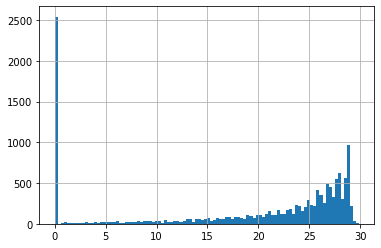

In [75]:
dataset['icu_free_days'].hist(bins=100)

#### C) Predicted weight

<AxesSubplot:>

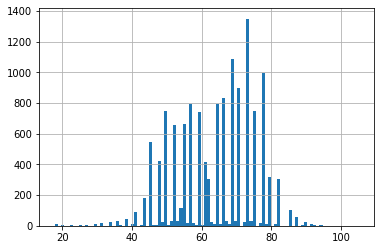

<AxesSubplot:>

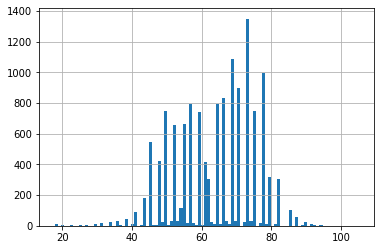

In [77]:
def compute_ideal_weight(height, gender):
    if gender == 'M':
        return 50 + 0.91 * (height - 152.4)
    else:
        return 45.5 + 0.91 * (height - 152.4)

dataset['ideal_weight'] = dataset.apply(
    lambda x: compute_ideal_weight(x.height, x.gender),
    axis=1
)
dataset['ideal_weight'].hist(bins=100)

#### D) Tidal Volume [ml / kg]

/Users/ricardokleinlein/Desktop/Personal/MIT/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<AxesSubplot:>

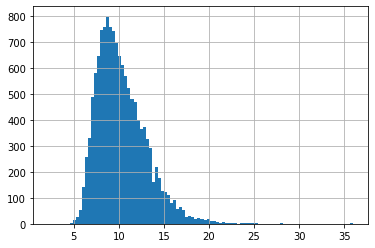

In [78]:
def compute_norm_tidal(tidal_ml, ideal_weight):
    if numpy.isnan(tidal_ml):
        return numpy.nan
    return float(tidal_ml / ideal_weight)

dataset = dataset[dataset['tidal_volume_observed'] < 1500]

dataset['tidal'] = dataset.apply(
    lambda x: compute_norm_tidal(x.tidal_volume_observed, x.ideal_weight),
    axis=1
)
dataset = dataset[dataset['ventilation_status'] == 'InvasiveVent']
dataset['tidal'].hist(bins=100)

#### Final dataframe (with all columns)

In [10]:
renamed_cols = {'_223835': 'Inspired O2 Fraction',
                '_224695': 'Peak Insp. Pressure'}
dataset = dataset.rename(columns=renamed_cols)
dataset

,Unnamed: 0,subject_id,stay_id,respiratory_rate_total,minute_volume,tidal_volume_observed,plateau_pressure,peep,fio2,outcome_los,...,liver,cardiovascular,cns,renal,weight,neuroblock,charlson_comorbidity_index,Inspired O2 Fraction,Peak Insp. Pressure,mechanical_power
0,0,10734403,36647759,24.0,12.0,855.0,20.0,15.0,100.0,3.923854,...,0.0,1.0,0.0,3.0,94.90,1,6.0,80.540541,25.333333,45.916920
1,1,12341414,34948580,29.0,11.5,548.0,NaN,5.0,50.0,2.911609,...,1.0,0.0,1.0,3.0,86.20,0,5.0,50.000000,14.000000,NaN
2,2,16427415,37704589,27.0,11.1,505.0,NaN,5.0,50.0,3.079306,...,0.0,4.0,0.0,0.0,58.40,0,4.0,40.833333,11.718182,NaN
3,3,14755447,36062702,35.0,10.3,390.0,19.0,5.0,100.0,1.110336,...,NaN,1.0,1.0,0.0,81.35,0,5.0,50.000000,21.500000,19.396650
8,8,11958726,34483718,29.0,16.2,531.0,22.0,8.0,100.0,8.789780,...,0.0,1.0,4.0,1.0,98.00,0,6.5,41.046512,16.035714,13.635815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58848,58848,10597591,32987362,22.0,10.6,502.0,18.0,5.0,100.0,1.333576,...,NaN,1.0,0.0,0.0,63.20,0,5.0,44.000000,21.000000,15.693524
58849,58849,13102017,30580472,22.0,7.9,393.0,20.0,10.0,100.0,1.066771,...,NaN,1.0,0.0,1.0,76.30,0,5.0,48.333333,19.666667,12.427184
58850,58850,13102017,30580472,22.0,7.9,393.0,20.0,10.0,100.0,1.066771,...,NaN,1.0,0.0,1.0,76.30,0,5.0,48.333333,19.666667,12.427184
58856,58856,15725162,35197996,25.0,9.6,577.0,22.0,10.0,100.0,3.256389,...,NaN,3.0,0.0,0.0,101.50,0,3.0,70.000000,23.700000,25.021605


#### Remove unrelevant columns

As suggested by clinicians.

In [80]:
cols2remove = ['outcome_los', 'ethnicity', 'language', 'outcome_death',
               'ventilation_status']
dataset = dataset.drop(columns=cols2remove)
dataset

,Unnamed: 0,subject_id,stay_id,respiratory_rate_total,minute_volume,tidal_volume_observed,plateau_pressure,peep,fio2,admission_type,...,renal,weight,neuroblock,charlson_comorbidity_index,Inspired O2 Fraction,Peak Insp. Pressure,mechanical_power,icu_free_days,ideal_weight,tidal
0,0,10734403,36647759,24.0,12.0,855.0,20.0,15.0,100.0,URGENT,...,3.0,94.90,1,6.0,80.540541,25.333333,45.916920,0.000000,73.296,11.665029
1,8,11958726,34483718,29.0,16.2,531.0,22.0,8.0,100.0,URGENT,...,1.0,98.00,0,6.5,41.046512,16.035714,13.635815,21.210220,55.146,9.628985
2,20,13946340,36398287,28.0,14.5,528.0,31.0,17.5,100.0,URGENT,...,1.0,213.00,0,8.0,58.000000,32.380000,37.133564,0.000000,77.846,6.782622
3,27,16423390,30742542,34.0,21.0,808.0,25.0,15.0,100.0,URGENT,...,0.0,75.00,0,8.0,59.295858,20.522727,41.791156,0.000000,59.696,13.535245
4,29,17730739,37639927,20.0,10.7,600.0,24.0,8.0,100.0,URGENT,...,0.0,101.80,0,6.0,57.142857,31.750000,27.930000,28.017523,56.966,10.532598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13728,58839,12318910,31625495,16.0,8.2,525.0,24.0,5.0,100.0,SURGICAL SAME DAY ADMISSION,...,0.0,69.55,0,6.0,56.000000,18.750000,7.614600,26.548889,47.866,10.968119
13729,58841,12176219,34535596,14.0,7.3,535.0,17.0,5.0,100.0,SURGICAL SAME DAY ADMISSION,...,0.0,93.20,0,3.5,53.571429,22.500000,12.111330,29.051759,64.196,8.333853
13730,58847,10597591,32987362,22.0,10.6,502.0,18.0,5.0,100.0,SURGICAL SAME DAY ADMISSION,...,0.0,63.20,0,5.0,44.000000,21.000000,15.693524,28.666424,66.016,7.604217
13731,58849,13102017,30580472,22.0,7.9,393.0,20.0,10.0,100.0,SURGICAL SAME DAY ADMISSION,...,1.0,76.30,0,5.0,48.333333,19.666667,12.427184,28.933229,59.696,6.583356


### Data normalization

Categorical data -> Ordinal encoder, turning every category into an integer

In [46]:
categorical_vars = dataset.select_dtypes('object').columns.tolist()
dataset2 = dataset.copy()
for col in categorical_vars:
    col_no_nan = dataset[col].dropna().unique()
    categorical_transformer = {key: i for i, key in enumerate(col_no_nan)}
    dataset2 = dataset2.replace({col: categorical_transformer})
dataset2

,Unnamed: 0,subject_id,stay_id,respiratory_rate_total,minute_volume,tidal_volume_observed,plateau_pressure,peep,fio2,admission_type,...,renal,weight,neuroblock,charlson_comorbidity_index,Inspired O2 Fraction,Peak Insp. Pressure,mechanical_power,icu_free_days,ideal_weight,tidal
0,0,10734403,36647759,24.0,12.0,855.0,20.0,15.0,100.0,0,...,3.0,94.90,1,6.0,80.540541,25.333333,45.916920,0.000000,73.296,11.665029
4,8,11958726,34483718,29.0,16.2,531.0,22.0,8.0,100.0,0,...,1.0,98.00,0,6.5,41.046512,16.035714,13.635815,21.210220,55.146,9.628985
9,20,13946340,36398287,28.0,14.5,528.0,31.0,17.5,100.0,0,...,1.0,213.00,0,8.0,58.000000,32.380000,37.133564,0.000000,77.846,6.782622
10,27,16423390,30742542,34.0,21.0,808.0,25.0,15.0,100.0,0,...,0.0,75.00,0,8.0,59.295858,20.522727,41.791156,0.000000,59.696,13.535245
12,29,17730739,37639927,20.0,10.7,600.0,24.0,8.0,100.0,0,...,0.0,101.80,0,6.0,57.142857,31.750000,27.930000,28.017523,56.966,10.532598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,58839,12318910,31625495,16.0,8.2,525.0,24.0,5.0,100.0,5,...,0.0,69.55,0,6.0,56.000000,18.750000,7.614600,26.548889,47.866,10.968119
32997,58841,12176219,34535596,14.0,7.3,535.0,17.0,5.0,100.0,5,...,0.0,93.20,0,3.5,53.571429,22.500000,12.111330,29.051759,64.196,8.333853
32999,58847,10597591,32987362,22.0,10.6,502.0,18.0,5.0,100.0,5,...,0.0,63.20,0,5.0,44.000000,21.000000,15.693524,28.666424,66.016,7.604217
33001,58849,13102017,30580472,22.0,7.9,393.0,20.0,10.0,100.0,5,...,1.0,76.30,0,5.0,48.333333,19.666667,12.427184,28.933229,59.696,6.583356


In [47]:
numerical_vars = dataset.select_dtypes(include=numerics).columns.tolist()
numerical_vars = [s for s in numerical_vars if not '_id' in s]
numerical_vars = [s for s in numerical_vars if s != 'icu_free_days']

for col in numerical_vars:
    scaler = StandardScaler()
    null_index = dataset[col].isnull()
    dataset2.loc[~null_index, [col]] = scaler.fit_transform(
        dataset2.loc[~null_index, [col]]
    )

dataset2

,Unnamed: 0,subject_id,stay_id,respiratory_rate_total,minute_volume,tidal_volume_observed,plateau_pressure,peep,fio2,admission_type,...,renal,weight,neuroblock,charlson_comorbidity_index,Inspired O2 Fraction,Peak Insp. Pressure,mechanical_power,icu_free_days,ideal_weight,tidal
0,-1.680021,10734403,36647759,-0.153522,-0.024304,1.253567,-0.270434,1.166936,0.605394,0,...,1.528039,0.365196,3.536583,0.224521,2.773264,0.006809,0.028346,0.000000,0.834511,0.473482
4,-1.679552,11958726,34483718,0.067049,-0.008473,-0.694900,-0.032054,-0.209644,0.605394,0,...,-0.004827,0.487214,-0.282759,0.420371,-0.862414,-0.020239,-0.027642,21.210220,-0.772255,-0.246214
9,-1.678847,13946340,36398287,0.022935,-0.014881,-0.712941,1.040660,1.658572,0.605394,0,...,-0.004827,5.013656,-0.282759,1.007922,0.698263,0.027309,0.013112,0.000000,1.237309,-1.252339
10,-1.678437,16423390,30742542,0.287619,0.009619,0.970919,0.325518,1.166936,0.605394,0,...,-0.771259,-0.418075,-0.282759,1.007922,0.817555,-0.007186,0.021190,0.000000,-0.369457,1.134561
12,-1.678319,17730739,37639927,-0.329978,-0.029204,-0.279948,0.206327,-0.209644,0.605394,0,...,-0.771259,0.636783,-0.282759,0.224521,0.619358,0.025477,-0.002850,28.017523,-0.611136,0.073193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,1.772672,12318910,31625495,-0.506435,-0.038626,-0.730982,0.206327,-0.799606,0.605394,5,...,-0.771259,-0.632589,-0.282759,0.224521,0.514150,-0.012343,-0.038085,26.548889,-1.416732,0.227140
32997,1.772789,12176219,34535596,-0.594663,-0.042019,-0.670844,-0.628006,-0.799606,0.605394,5,...,-0.771259,0.298284,-0.282759,-0.754731,0.290585,-0.001433,-0.030286,29.051759,0.028915,-0.704014
32999,1.773141,10597591,32987362,-0.241750,-0.029581,-0.869299,-0.508815,-0.799606,0.605394,5,...,-0.771259,-0.882527,-0.282759,-0.167180,-0.590526,-0.005797,-0.024073,28.666424,0.190034,-0.961924
33001,1.773258,13102017,30580472,-0.241750,-0.039757,-1.524802,-0.270434,0.183665,0.605394,5,...,-0.004827,-0.366906,-0.282759,-0.167180,-0.191615,-0.009676,-0.029738,28.933229,-0.369457,-1.322776


### Impute unknown/missing values (mean value)

In [48]:
filled_na_dataset = dataset2.fillna(value=dataset2.mean())
filled_na_dataset

,Unnamed: 0,subject_id,stay_id,respiratory_rate_total,minute_volume,tidal_volume_observed,plateau_pressure,peep,fio2,admission_type,...,renal,weight,neuroblock,charlson_comorbidity_index,Inspired O2 Fraction,Peak Insp. Pressure,mechanical_power,icu_free_days,ideal_weight,tidal
0,-1.680021,10734403,36647759,-0.153522,-0.024304,1.253567,-0.270434,1.166936,0.605394,0,...,1.528039,0.365196,3.536583,0.224521,2.773264,0.006809,0.028346,0.000000,0.834511,0.473482
4,-1.679552,11958726,34483718,0.067049,-0.008473,-0.694900,-0.032054,-0.209644,0.605394,0,...,-0.004827,0.487214,-0.282759,0.420371,-0.862414,-0.020239,-0.027642,21.210220,-0.772255,-0.246214
9,-1.678847,13946340,36398287,0.022935,-0.014881,-0.712941,1.040660,1.658572,0.605394,0,...,-0.004827,5.013656,-0.282759,1.007922,0.698263,0.027309,0.013112,0.000000,1.237309,-1.252339
10,-1.678437,16423390,30742542,0.287619,0.009619,0.970919,0.325518,1.166936,0.605394,0,...,-0.771259,-0.418075,-0.282759,1.007922,0.817555,-0.007186,0.021190,0.000000,-0.369457,1.134561
12,-1.678319,17730739,37639927,-0.329978,-0.029204,-0.279948,0.206327,-0.209644,0.605394,0,...,-0.771259,0.636783,-0.282759,0.224521,0.619358,0.025477,-0.002850,28.017523,-0.611136,0.073193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,1.772672,12318910,31625495,-0.506435,-0.038626,-0.730982,0.206327,-0.799606,0.605394,5,...,-0.771259,-0.632589,-0.282759,0.224521,0.514150,-0.012343,-0.038085,26.548889,-1.416732,0.227140
32997,1.772789,12176219,34535596,-0.594663,-0.042019,-0.670844,-0.628006,-0.799606,0.605394,5,...,-0.771259,0.298284,-0.282759,-0.754731,0.290585,-0.001433,-0.030286,29.051759,0.028915,-0.704014
32999,1.773141,10597591,32987362,-0.241750,-0.029581,-0.869299,-0.508815,-0.799606,0.605394,5,...,-0.771259,-0.882527,-0.282759,-0.167180,-0.590526,-0.005797,-0.024073,28.666424,0.190034,-0.961924
33001,1.773258,13102017,30580472,-0.241750,-0.039757,-1.524802,-0.270434,0.183665,0.605394,5,...,-0.004827,-0.366906,-0.282759,-0.167180,-0.191615,-0.009676,-0.029738,28.933229,-0.369457,-1.322776


In [49]:
features_patient_parameters = ['admission_type', 'gender',
                               'age_at_admission', 'height', 'SOFA',
                               'respiration', 'coagulation', 'liver',
                               'cardiovascular', 'cns', 'renal', 'weight',
                               'charlson_comorbidity_index']

features_ventilation_parameters = list(
    set(list(filled_na_dataset)) - set(features_patient_parameters) - set
    (['hadm_id', 'tidal_volume_observed', 'ideal_weight', 'icu_free_days',
      'stay_id', 'subject_id', 'Unnamed: 0'])
)

## Clustering (using all features)

In [50]:
class Hdbscan:
    def __init__(self, min_cluster_size: int, metric: str = 'euclidean') -> \
            None:
        """
        Perform HDBSCAN clustering.

        Args:
         min_cluster_size (min): Minimum amount of samples to set a cluster.
         metric (str): Distance measure.
        """
        self.method = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            metric=metric,
            cluster_selection_method='eom')

    def fit(self, X: numpy.ndarray) -> None:
        self.method.fit(X)

    def get_labels(self) -> numpy.ndarray:
        return self.method.labels_

    def get_core_samples(self) -> list:
        """
        Select only the most representative samples per cluster.

        Returns:
            list:
        """
        core_samples = []
        for cluster, core in enumerate(self.method.exemplars_):
            core_samples.append((cluster, len(core)))
        return core_samples

    def measure_cluster_size(self):
        """
        Compute the number of labels for the elements
        unique.

        Returns:
            List:tuple
        """
        labels = self.get_labels()
        unique = sorted(list(set(labels)))
        clus_size = []
        for i, cluster in enumerate(unique[1:]):
            clus_size.append((cluster, len(numpy.where(labels == cluster)[0])))
        return clus_size

    def avg_score_by_label(self, scores,
                           allow_noise: bool = False):
        """
        Using the outcome of the clustering, aggregate input scores by the
        predicted labels.

        Args:
            scores (Union[list, numpy.ndarray]): Scores to aggregate.

        Returns:
            Dict[int, float]

        NOTE: Scores must match the ordering of the data the method is
        trained on.
        """
        if isinstance(scores, list):
            scores = numpy.array(scores)
        labels = self.get_labels()
        unique_labels = sorted(list(set(labels)))
        score_per_label = dict()
        for i, cluster in enumerate(unique_labels):
            cluster_samples = numpy.where(labels == cluster)[0]
            cluster_scores = scores[cluster_samples]
            score_per_label[cluster] = cluster_scores
        return score_per_label

In [54]:
# Select data and perform clustering
features_all_cols = features_patient_parameters + \
                   features_ventilation_parameters
features_data = filled_na_dataset[features_all_cols].values
hdbscaner = Hdbscan(15)
hdbscaner.fit(features_data)
print(hdbscaner.measure_cluster_size())

[(0, 863), (1, 12407)]


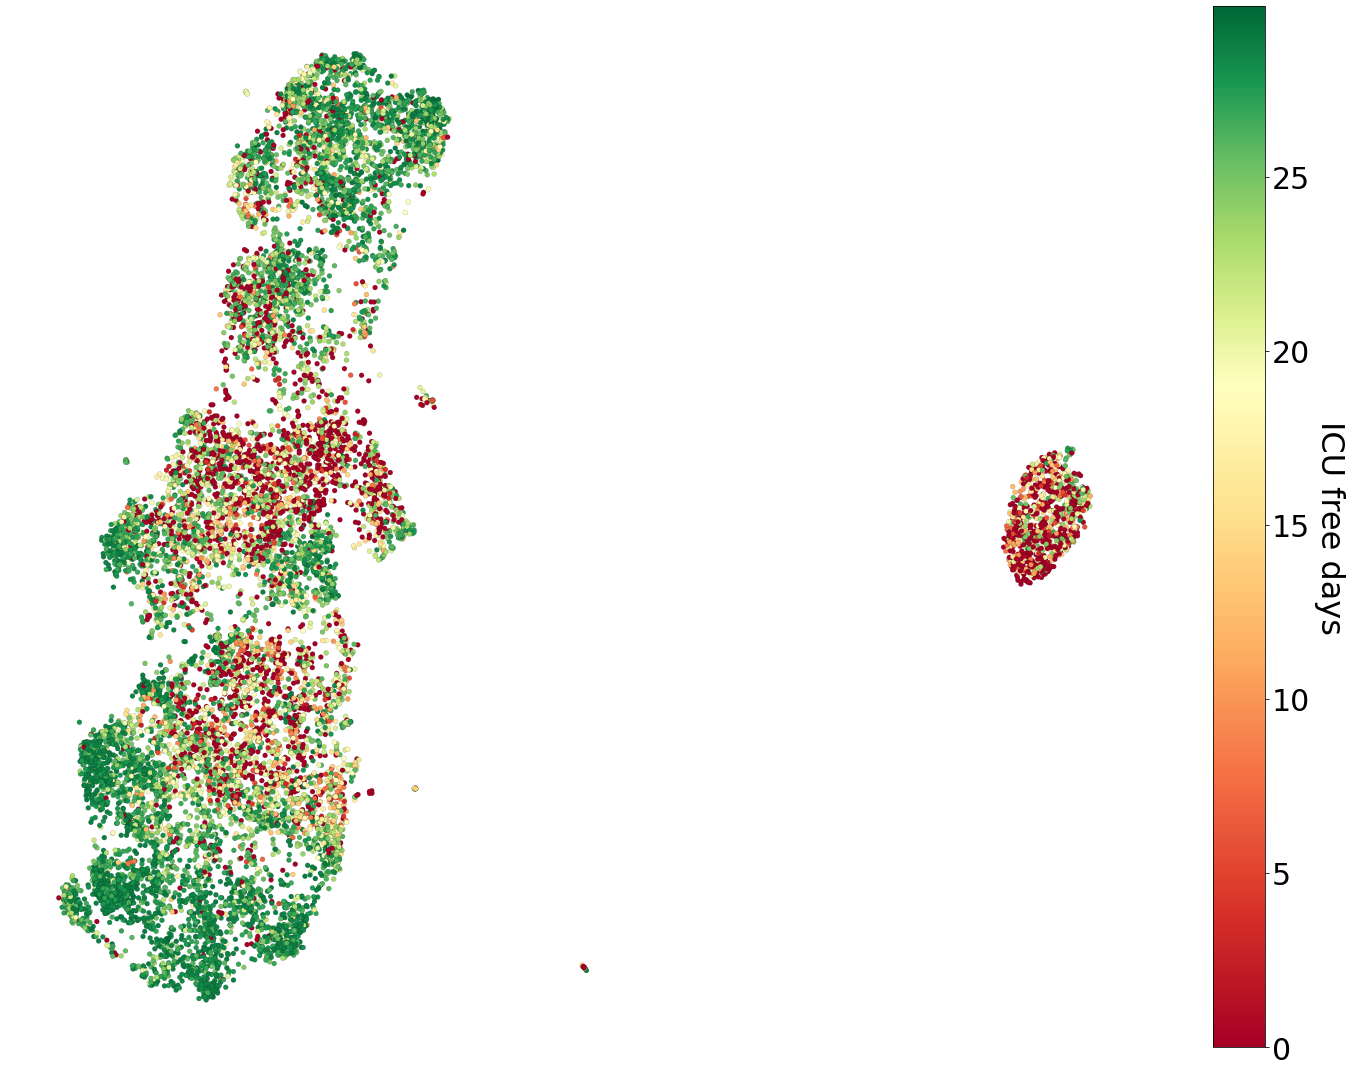

In [59]:
# Data dimensionality reduction
class Umap:
    seed = 1234

    def __init__(self, dims: int, nneighs: int, metric: str ='cosine') -> None:
        """
        Wrapper for UMAP from umap-learn.
        Args:
            dims (int): Dimension of the projected space.
            nneighs (int): Proximity parameter.
            metric (str): Distance measure.
        """
        self.umap = umap.UMAP(n_neighbors=nneighs, n_components=dims,
                              metric=metric, random_state=self.seed)

    def __call__(self, X: numpy.ndarray) -> numpy.ndarray:
        return self.umap.fit_transform(X)


def scored_scatter(
        X: Union[List[numpy.ndarray], numpy.ndarray],
        scores: Union[list, numpy.ndarray],
        score_name: str,
        point_size: int = 25
)-> None:
    """
    Plot a scatter of points whose color is determined by a score label.
    Args:
        X (Union[List[numpy.ndarray], numpy.ndarray]): (N, 2) Input data.
        scores (Union[list, numpy.ndarray]): (N,) score labels.
        score_name (str): Name of the score used.
        point_size (int): Point size in the plot.
    """
    mu = numpy.mean(scores)
    lower = min(scores)
    upper = max(scores)
    fig, ax = plt.subplots(figsize=(20, 15))
    norm = colors.TwoSlopeNorm(
        vmin=lower,
        vmax=upper,
        vcenter=mu
    )
    scatter = ax.scatter(X[:, 0], X[:, 1], s=point_size, c=scores,
                         cmap=cm.get_cmap('RdYlGn'), norm=norm,
                         edgecolor='k', linewidth=0.1)
    plt.axis('off')
    cbar = fig.colorbar(scatter)
    cbar.ax.get_yaxis().labelpad = 35
    cbar.ax.tick_params(labelsize=30)
    cbar.ax.set_ylabel(score_name, rotation=270, fontsize=32)
    plt.tight_layout()
    plt.show()


umaper = Umap(2, 25)
data_reduced = umaper(features_data)
scored_scatter(data_reduced,
               scores=dataset2.icu_free_days,
               score_name='ICU free days')

In [82]:
dataset['clustering-all-label'] = hdbscaner.get_labels()
dataset.to_csv('clustering_all_features.csv')

## Patient parameters

In [87]:
features_patient = features_patient_parameters
features_data = filled_na_dataset[features_patient].values
hdbscaner = Hdbscan(15)
hdbscaner.fit(features_data)
print(hdbscaner.measure_cluster_size())

[(0, 48), (1, 85), (2, 2449)]


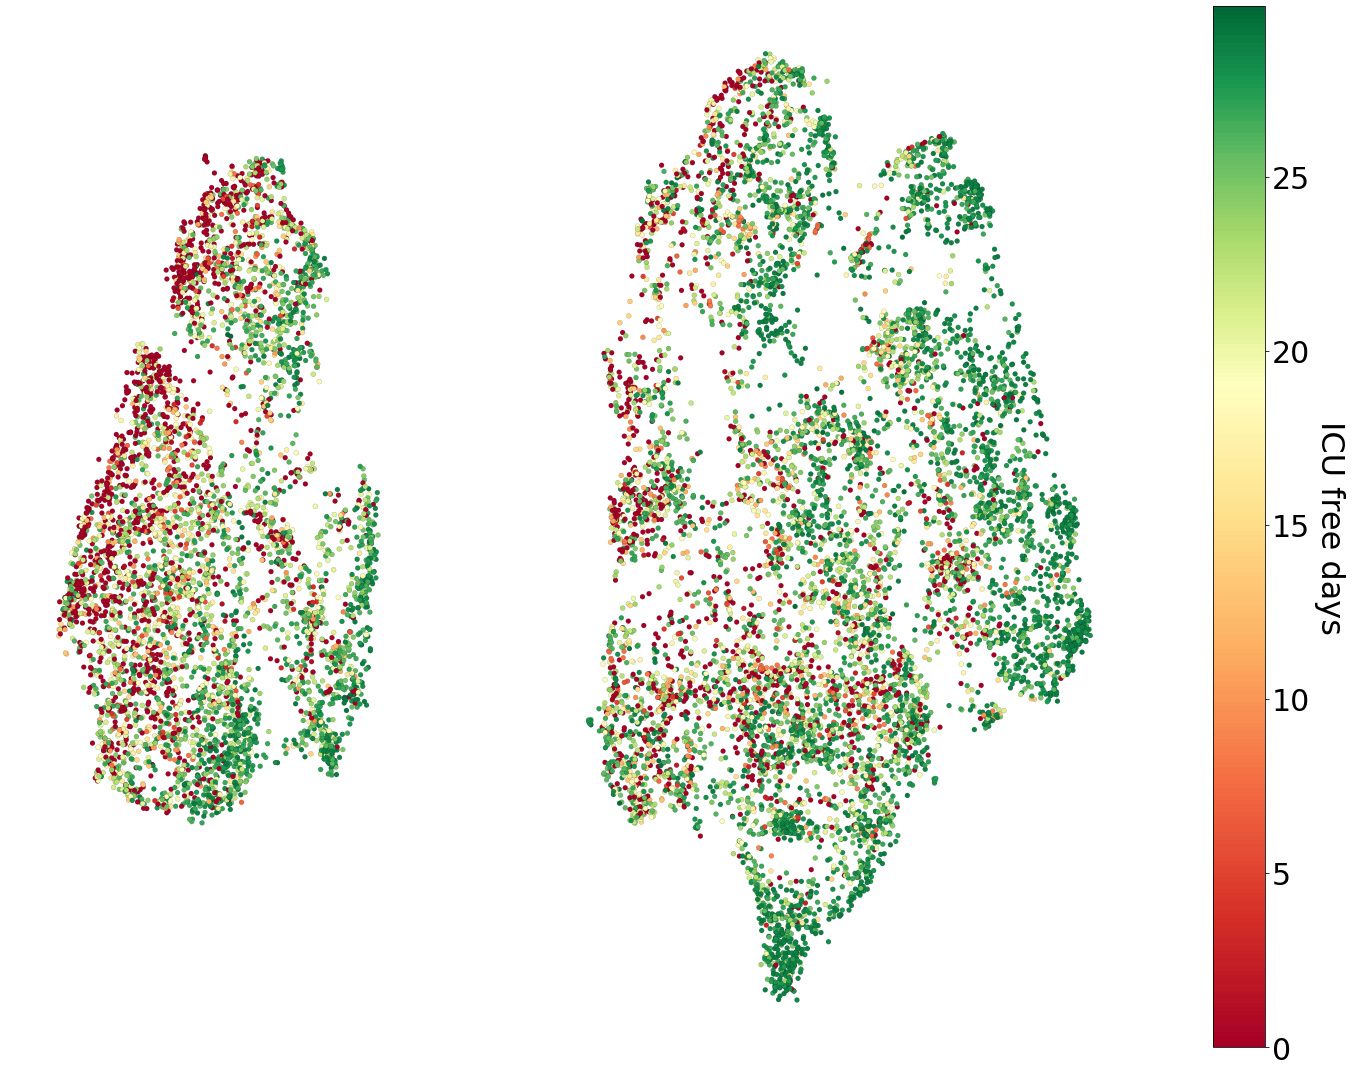

In [88]:
umaper = Umap(2, 25)
data_reduced = umaper(features_data)
scored_scatter(data_reduced,
               scores=dataset2.icu_free_days,
               score_name='ICU free days')

In [89]:
dataset['clustering-patient-parameters-label'] = hdbscaner.get_labels()
dataset.to_csv('clustering-patient-parameters-label.csv')

## Ventilation parameters

In [90]:
features_patient = features_ventilation_parameters
features_data = filled_na_dataset[features_ventilation_parameters].values
hdbscaner = Hdbscan(15)
hdbscaner.fit(features_data)
print(hdbscaner.measure_cluster_size())

[(0, 1001), (1, 16), (2, 12578)]


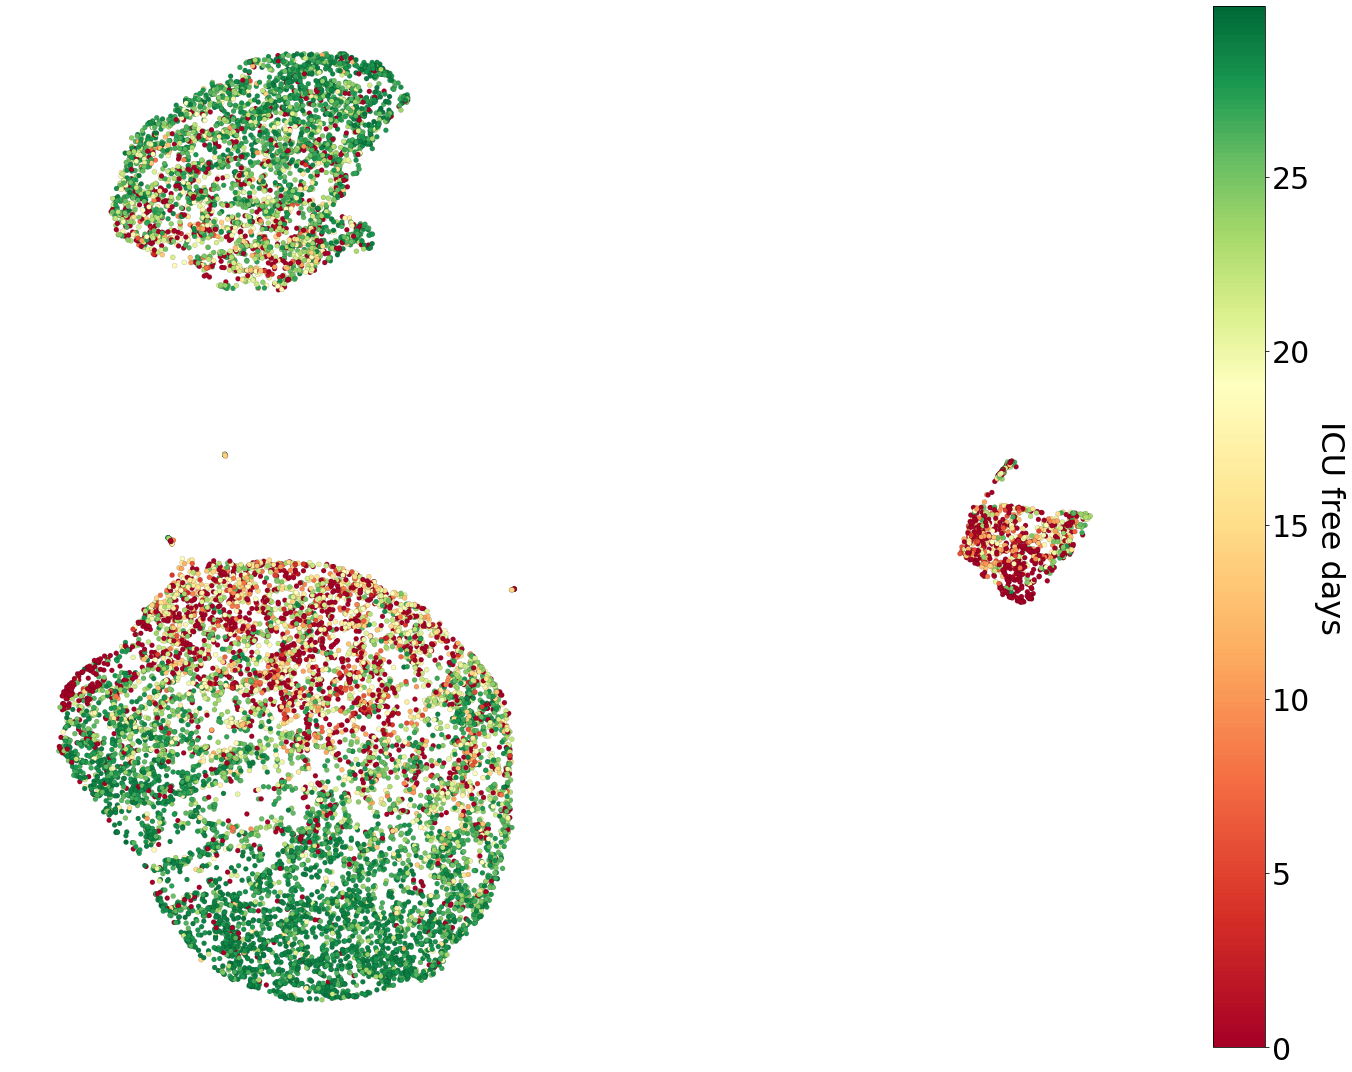

In [91]:
umaper = Umap(2, 25)
data_reduced = umaper(features_data)
scored_scatter(data_reduced,
               scores=dataset2.icu_free_days,
               score_name='ICU free days')

In [92]:
dataset['clustering-ventilation-label'] = hdbscaner.get_labels()
dataset.to_csv('clustering-ventilation-parameters.csv')